In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## 1. 前処理 (続き)

In [3]:
df = pd.read_csv('result_color.csv')
df.head()

,subj,ink,text,RT
0,1,B,緑,415.0
1,1,B,赤,530.0
2,1,B,青,372.0
3,1,G,緑,453.0
4,1,G,赤,557.0


In [4]:
df_groupby = df.groupby(by=['ink', 'text'])
df_mean = df_groupby['RT'].mean()
df_sem = df_groupby['RT'].sem()

In [5]:
def cilen(arr, alpha=0.95):  # 両側95%信頼区間
    m, e, df = np.mean(arr), stats.sem(arr), len(arr) - 1
    interval = stats.t.interval(alpha, df, loc=m, scale=e)
    cilen = np.max(interval) - np.mean(interval)
    return cilen

df_ci = df_groupby['RT'].apply(cilen)

## 2. 可視化 (棒グラフ)
2要因の場合，論文用の図を作るのは，慣れなければ辛かったりする．無理せずExcelのほうが良いかもしれない．<br>
作図方法については[公式のギャラリー](http://matplotlib.org/gallery.html)を参照すると良い．

※ 特に，matplotlibと棒グラフは**すこぶる**相性が悪い．

In [6]:
table_mean = df_mean.unstack()
table_sem = df_sem.unstack()
table_ci = df_ci.unstack()
table_mean

text,緑,赤,青
ink,,,
B,471.091667,486.433333,402.950000
G,398.933333,482.543333,485.033333
R,466.000000,357.250000,448.750000


### 2.1. ざっくりプロット

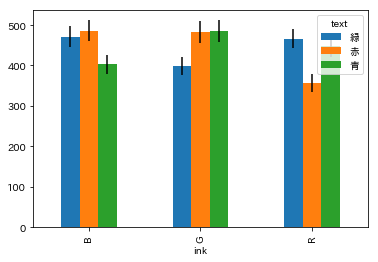

In [7]:
table_mean.plot(kind='bar', yerr=table_ci)

### 2.2. しっかりプロット

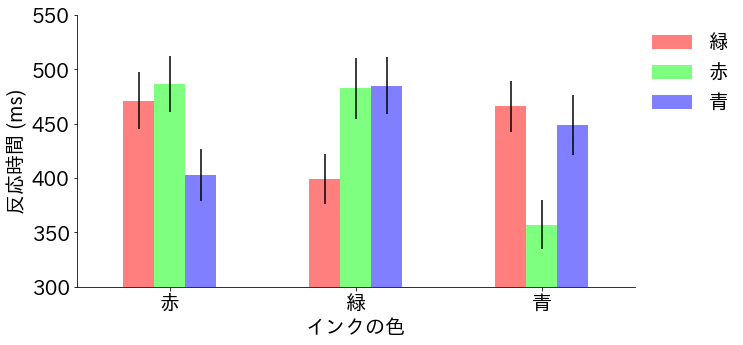

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

table_mean.plot(
    kind='bar',
    rot=0,
    yerr=table_ci,
    color=[[1, 0, 0, 0.5], [0, 1, 0, 0.5], [0, 0, 1, 0.5]],  # in RGBa
    fontsize=20,
    legend=False,
    ax=ax
    )

ax.set_xlabel('インクの色', fontsize=20)
ax.set_ylabel('反応時間 (ms)', fontsize=20)
ax.set_xticklabels(['赤', '緑', '青'])
ax.set_ylim(300, 550)
ax.legend(frameon=False, fontsize=20, bbox_to_anchor=(1.2, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

###  2.3. がっつりプロット
もはやおまけ編．何もかも完全に指定しようとするといつの間にかこんな感じになる．でもここまでやるならExcelでいいと思います．

なぜこんなに面倒なのかというと，matplotlibの棒グラフは，「xの位置に高さyの棒を書く」ことによって作図されるためです．<br>
つまり，棒を置きたいx座標を全部自分で指定する必要があります．

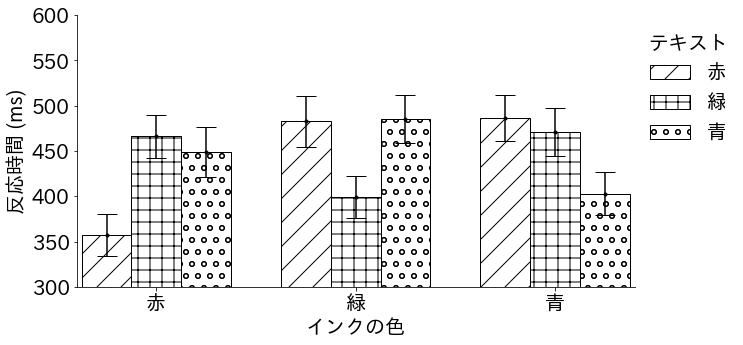

In [9]:
rownames= ['R', 'G', 'B']
colnames = ['赤', '緑', '青']
table_mean = table_mean.loc[rownames, colnames]  # RGBで並び替えしておく
table_sem = table_sem.loc[rownames, colnames]
table_ci = table_ci.loc[rownames, colnames]

ymin, ymax = 300, 600
nrow, ncol = table_mean.shape
xticks = np.arange(nrow)
yticks = np.arange(ymin, ymax + 1, 50)
margin = (xticks.max() - xticks.min()) * 0.2
width = 1 / (ncol + 1)
xfix = width * (np.arange(ncol) - np.arange(ncol).mean())
hatches = ['/', '+', 'o']

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(ncol):
    x = xticks + xfix[i]
    y = table_mean.iloc[:, i].values
    yerr = table_ci.iloc[:, i].values
    ax.bar(x, y, width=width,
           edgecolor='black', color='white', hatch=hatches[i], label=colnames[i])
    ax.errorbar(x, y, yerr, color='black', fmt='.', capsize=10)
    
ax.legend(title='テキスト', frameon=False, fontsize=20, bbox_to_anchor=(1.2, 1.0))
ax.get_legend().get_title().set_fontsize(20)

ax.set_xlabel('インクの色', fontsize=20)
ax.set_xlim(-margin, max(xticks) + margin)
ax.set_xticks(xticks)
ax.set_xticklabels(colnames, fontsize=20)

ax.set_ylabel('反応時間 (ms)', fontsize=20)
ax.set_ylim(ymin, ymax)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

## 3. 分析 (分散分析)
やっぱりRが一番強い

In [10]:
%%R
source('anovakun_462.txt')
dat <- read.csv('result_color.csv')
head(dat)

  subj ink text  RT
1    1   B   緑 415
2    1   B   赤 530
3    1   B   青 372
4    1   G   緑 453
5    1   G   赤 557
6    1   G   青 407


In [11]:
%%R
anovakun(dat, 'sAB', long=T, peta=T, holm=T)


[ sAB-Type Design ] 
 
This output was generated by anovakun 4.6.2 under R version 3.3.2. 
It was executed on Sun Feb 12 03:43:36 2017. 
 
 
<< DESCRIPTIVE STATISTICS >>

------------------------------------
 ink  text   n      Mean     S.D. 
------------------------------------
   B   緑  20  471.0917  56.3254 
   B   赤  20  486.4333  55.1301 
   B   青  20  402.9500  50.5272 
   G   緑  20  398.9333  49.2082 
   G   赤  20  482.5433  59.6505 
   G   青  20  485.0333  56.4329 
   R   緑  20  466.0000  50.0852 
   R   赤  20  357.2500  48.8577 
   R   青  20  448.7500  58.8325 
------------------------------------


<< SPHERICITY INDICES >>

== Mendoza's Multisample Sphericity Test and Epsilons == 
 
----------------------------------------------------------------------------
     Effect  Lambda  approx.Chi  df       p         LB     GG     HF     CM 
----------------------------------------------------------------------------
     Global  0.0000     32.2165  35  0.6242 ns  0.1250 0.7020 1.03